# Differential evolution in JAX

Differential evolution is a powerful, gradient-free global optimisation algorithm. `devojax` provides a lightweight interface for performing differential evolution on both CPUs and accelerator hardware, with support for both JAX and JAX-free objective functions. In the latter case, the user must handle the interface with the accelerator.

In [1]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt

from devojax import DifferentialEvolution

As an example, we will consider the two-dimensional Rastrigin function

$$ f(x) = x^2 - y^2 + 10(2 - \cos(2 \pi x) - \cos(2 \pi y)) \, ,$$

which is a common benchmark for optimisation algorithms.

`devojax` passes a 3D array of shape $(N_\mathrm{pop}, N_\mathrm{perpop}, N_\mathrm{dim})$, with the last axis corresponding to the function arguments. It similarly expects to receive a 2D array of shape $(N_\mathrm{pop}, N_\mathrm{perpop})$ from the objective function.

In [2]:
def rastrigin(parameters):
    x = parameters[:,:,0]
    y = parameters[:,:,1]

    return x*x + y*y + 10 * (2 - jnp.cos(2 * jnp.pi * x) - jnp.cos(2 * jnp.pi * y))

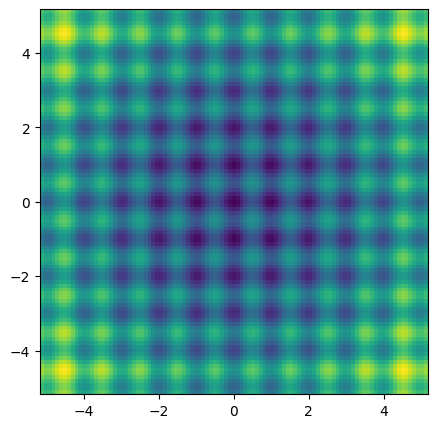

In [3]:
xv = jnp.linspace(-5.12, 5.12, 101)
yv = jnp.linspace(-5.12, 5.12, 101)

xg, yg = jnp.meshgrid(xv, yv, indexing='ij')
zg = rastrigin(jnp.hstack((xg.flatten()[:,None], yg.flatten()[:,None]))[None,...])[0].reshape(xv.size, yv.size)

fig = plt.figure(figsize=(5,5))
plt.pcolormesh(xv, yv, zg.T)


`devojax` takes an objective function, array of bounds, a `jax.random.key` instance and a set of control parameters typical of differential evolution:

In [4]:
bounds = jnp.array([
    [-5.12, 5.12],
    [-5.12, 5.12]
])

de = DifferentialEvolution(
    rastrigin,
    bounds,
    jax.random.key(1729),
    nperpop=15,  # will be scaled by the number of dimensions
    npop=1,  # number of distinct populations to evolve
    recombination=0.7,  # "CR" recombination parameter. Sets evolution rate. 
    mutation=0.5,  # "F" mutation parameter. Scales adjustments to population.
    tol = 1e-2,  # relative tolerance with respect to population. Truncates solve when populations are clustered.
    strategy='best',  # either "best" or "rand" to determine pivot member for each agent update
    maxiter=100,  # maximum number of iterations before solve converges
    jittable_func=True,  # indicates if objective is JAX-compatible or not. Setting to True is more efficient if possible.
)

Calling the instantiated object triggers the solve. A set of agent positions can be passed at this stage via the `initial_positions` kwarg, otherwise random populations are instantiated via latin hypercube sampling.

In [5]:
(positions, statistics) = de()

From the final state, we can see that the optimiser has converged to the true solution $(x, y) = (0, 0)$ with $f(0, 0) = 0$.

In [6]:
best = statistics.argmin(1)

positions[0, best], statistics[0, best], de.nfev

(Array([[-5.8262548e-11, -4.6591425e-11]], dtype=float32),
 Array([5.5652853e-21], dtype=float32),
 1620)

The step-by-step evolution of the system state is accessible via the `pos` and `stat` attributes:

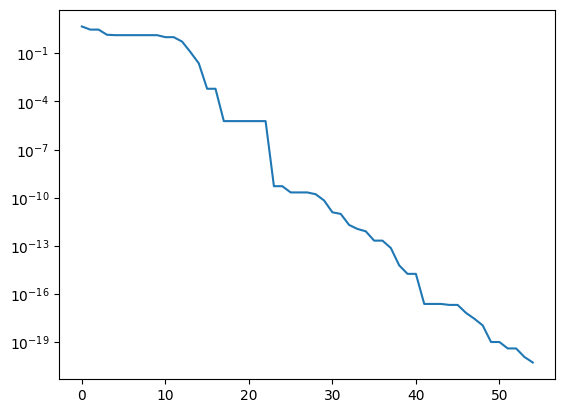

In [7]:
plt.semilogy(jnp.array(de.stat)[:,0].min(1))
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


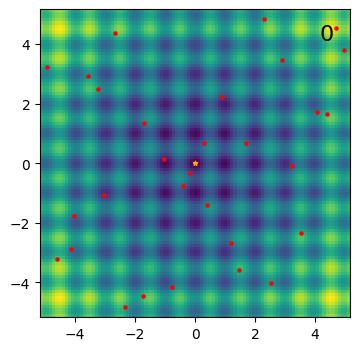

In [8]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(4,4))
ax.pcolormesh(xv, yv, zg.T)

ax.scatter([0], [0], c='orange', marker='*', s=10)
scat = ax.scatter(*de.pos[0][0].T, c='red', s=5)
text = ax.text(0.9, 0.9, '0', transform=ax.transAxes, fontsize=16)

def update(frame):
    scat.set_offsets(de.pos[frame][0])
    text.set_text(f'{frame}')
    return (scat, text)

ani = FuncAnimation(fig=fig, func=update, frames=len(de.pos), interval=10)
ani.save('de.gif', fps=60)

## Multiple populations

With `devojax`, multiple optimisation problems can be solved simultaneously. These can be instances of the same problem (e.g., to provide additional robustness to local maxima with respect to a single population) or different problems entirely (e.g., analysing many datasets simultaneously). The only requirement is that the problem set is expressed in terms of a single objective function.

Many of the control parameters in `devojax` also accept array inputs, allowing each solve to be tuned individually.

As a simple example, we can solve the Rastrigin function for `npop=10` populations with different mutation rates.

In [9]:
rates = jnp.linspace(0.05, 0.95, 10)

de_10 = DifferentialEvolution(
    rastrigin,
    bounds,
    jax.random.key(1729),
    npop=10,  # number of distinct populations to evolve
    mutation=rates,
    maxiter=100,  # maximum number of iterations before solve converges
    jittable_func=True,  # indicates if objective is JAX-compatible or not. Setting to True is more efficient if possible.
)

In [10]:
pos_10, stat_10 = de_10()

From this we can see that the rate of convergence depends very strongly indeed on the control parameters:

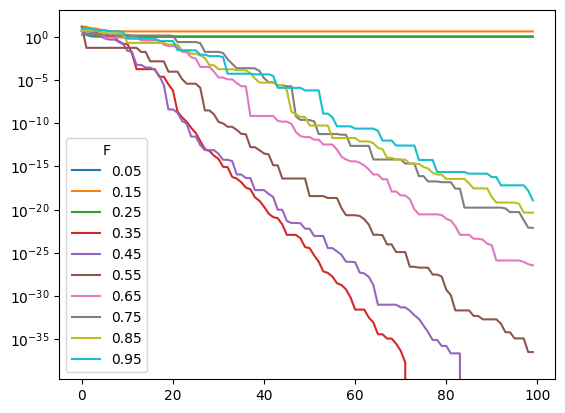

In [11]:
for k, rate in enumerate(rates):
    plt.semilogy(jnp.array(de_10.stat)[:,k].min(1), label=f'{rate:.2f}')
plt.legend(title='F')
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


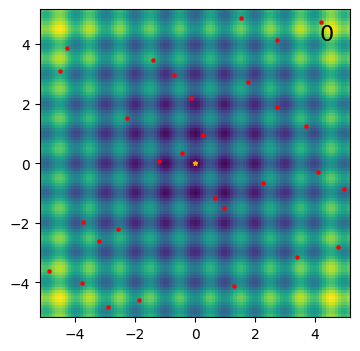

In [12]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(4,4))
ax.pcolormesh(xv, yv, zg.T)

check_run = -1

ax.scatter([0], [0], c='orange', marker='*', s=10)
scat = ax.scatter(*de_10.pos[0][check_run].T, c='red', s=5)
text = ax.text(0.9, 0.9, '0', transform=ax.transAxes, fontsize=16)

def update(frame):
    scat.set_offsets(de_10.pos[frame][check_run])
    text.set_text(f'{frame}')
    return (scat, text)

ani = FuncAnimation(fig=fig, func=update, frames=len(de_10.pos), interval=10)
ani.save('de_slow.gif', fps=60)